# 사용 패키지

In [ ]:
!pip install xgboost

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import lightgbm as lgb
#import xgboost as xgb
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


# 데이터 로드

In [92]:
total = pd.read_csv('./Data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
total.columns = ['date', 'hour', 'company', 'gas']


companys = total['company'].unique()
print(companys)
#company_map = dict()
for i, company in enumerate(companys):
    company_map[company] = i
#total['company'] = total['company'].map(company_map)
total['date'] = pd.to_datetime(total['date'])
total['year'] = total['date'].dt.year
total['month'] = total['date'].dt.month
total['day'] = total['date'].dt.day
total['weekday'] = total['date'].dt.weekday
total['weekend'] = 0
total.loc[total['weekday'] >= 5, 'weekend'] = 1

total.head()
total.shape

['A' 'B' 'C' 'D' 'E' 'G' 'H']


(368088, 9)

In [93]:
# creating one hot encoder object 
onehotencoder = OneHotEncoder()

#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(total[['company']]).toarray()

company_one_hot = pd.DataFrame(X, columns = ["Company_"+str(int(i)) for i in range(X.shape[1])]) 

total = pd.concat([total, company_one_hot], axis =1 )
total = total.drop(['company'], axis =1)

total = total[total['month'].isin([1,2,3])]
total.head()


,date,hour,gas,year,month,day,weekday,weekend,Company_0,Company_1,Company_2,Company_3,Company_4,Company_5,Company_6
0,2013-01-01,1,2497.129,2013,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2,2363.265,2013,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3,2258.505,2013,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,4,2243.969,2013,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,5,2344.105,2013,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
company_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [95]:

temps = []
for year in range(2013, 2019):
    temp = pd.read_csv(f'./Data/temperature_{year}.csv', encoding='cp949')
    #temp.columns = header
    temp = temp[['일시', '기온(°C)']]
    temp.columns = ['datetime', 'temperature']
    temp['datetime'] = pd.to_datetime(temp['datetime'])
    temp['year'] = temp['datetime'].dt.year
    temp['month'] = temp['datetime'].dt.month
    temp['day'] = temp['datetime'].dt.day
    temp['weekday'] = temp['datetime'].dt.weekday
    temp['hour'] = temp['datetime'].dt.hour + 1
    print(temp.shape)
    temps.append(temp)


(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8756, 7)
(8759, 7)


# 전처리

In [96]:
# interpolation for 2015

print(temps[2].head())
temps[2]['datetime'].iloc[0] = pd.to_datetime("2015-01-01 00:00:00")
temps[2]['year'].iloc[0] = 2015
temps[2]['month'].iloc[0] = 1
temps[2]['day'].iloc[0] = 1
temps[2]['weekday'].iloc[0] = 3
temps[2]['hour'].iloc[0] = 1

print(temps[2].head())


             datetime  temperature  year  month  day  weekday  hour
0 2014-12-31 23:00:00         -6.2  2014     12   31        2    24
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5
             datetime  temperature  year  month  day  weekday  hour
0 2015-01-01 00:00:00         -6.2  2015      1    1        3     1
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5


/home/bwj/anaconda3/envs/tf-env/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [97]:
# interpolation for 2017

missing_indices = pd.isnull(temps[-2].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0]
print(missing_indices)

print(temps[-2].iloc[6448:6450])    
print(temps[-2].iloc[6829:6835])

calc_temp = temps[-2]['temperature'].iloc[6448:6450].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2017-09-26 17:00:00"), 'temperature': calc_temp, "year": 2017, 'month': 9, 'day':26, \
                  'weekday':1, 'hour': 18}, index=[6449] )


lines = \
pd.DataFrame({"datetime": [pd.to_datetime("2017-10-12 15:00:00"), pd.to_datetime("2017-10-12 16:00:00"), pd.to_datetime("2017-10-12 17:00:00")], \
              'temperature': [13.5, 13.3, 13.1], \
              "year": [2017, 2017, 2017], 'month': [10, 10, 10], \
              'day':[12,12,12], 'weekday':[3,3,3], 'hour': [16,17,18]}, \
              index=[6830, 6831, 6832] )



temps[-2] = pd.concat([temps[-2].iloc[:6449], line, temps[-2].iloc[6449:6830], lines, temps[-2].iloc[6830:]]).reset_index(drop=True)

print(temps[-2].iloc[6448:6451])    
print(temps[-2].iloc[6829:6836])

[6449 6831 6832 6833]
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00         30.4  2017      9   26        1    17
6449 2017-09-26 18:00:00         27.9  2017      9   26        1    19
                datetime  temperature  year  month  day  weekday  hour
6829 2017-10-12 14:00:00         13.7  2017     10   12        3    15
6830 2017-10-12 18:00:00         12.8  2017     10   12        3    19
6831 2017-10-12 19:00:00         11.5  2017     10   12        3    20
6832 2017-10-12 20:00:00         10.6  2017     10   12        3    21
6833 2017-10-12 21:00:00         10.2  2017     10   12        3    22
6834 2017-10-12 22:00:00          9.7  2017     10   12        3    23
29.15
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00        30.40  2017      9   26        1    17
6449 2017-09-26 17:00:00        29.15  2017      9   26        1    18
6450 2017-09-26 18:00:00        27.90  2017      

/home/bwj/anaconda3/envs/tf-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
# interpolation for 2018

print(pd.isnull(temps[-1].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0])
print(temps[-1].iloc[7985:7987])

calc_temp = temps[-1]['temperature'].iloc[7985:7987].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2018-11-29 18:00:00"), 'temperature': calc_temp, "year": 2018, 'month': 11, 'day':29, \
                  'weekday':3, 'hour': 19}, index=[7986] )
temps[-1] = pd.concat([temps[-1].iloc[:7986], line, temps[-1].iloc[7986:]]).reset_index(drop=True)
                  
                  
print(temps[-1].iloc[7985:7987])


for i in range(len(temps)):
    print(temps[i].shape)


[7986]
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 19:00:00          5.2  2018     11   29        3    20
5.5
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 18:00:00          5.5  2018     11   29        3    19
(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8760, 7)
(8760, 7)


/home/bwj/anaconda3/envs/tf-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
temp_combined = pd.concat(temps, axis = 0)
temp_combined.reset_index(inplace=True, drop=True)
temp_combined.shape # should be 52584

(52584, 7)

In [100]:
join_df = pd.merge(total, temp_combined, how='left', left_on=['year', 'month', 'day', 'weekday', 'hour'], right_on=['year', 'month', 'day', 'weekday', 'hour'])
join_df.drop('datetime', axis=1, inplace=True)


print(join_df.shape)
print(total.shape)


print(join_df.iloc[:5])
print(total.iloc[:5])

(90888, 16)
(90888, 15)
        date  hour       gas  year  month  day  weekday  weekend  Company_0  \
0 2013-01-01     1  2497.129  2013      1    1        1        0        1.0   
1 2013-01-01     2  2363.265  2013      1    1        1        0        1.0   
2 2013-01-01     3  2258.505  2013      1    1        1        0        1.0   
3 2013-01-01     4  2243.969  2013      1    1        1        0        1.0   
4 2013-01-01     5  2344.105  2013      1    1        1        0        1.0   

   Company_1  Company_2  Company_3  Company_4  Company_5  Company_6  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   temperature  
0         -8.3  
1         -8.5  
2         -8.4  
3     

KeyError: 'company'

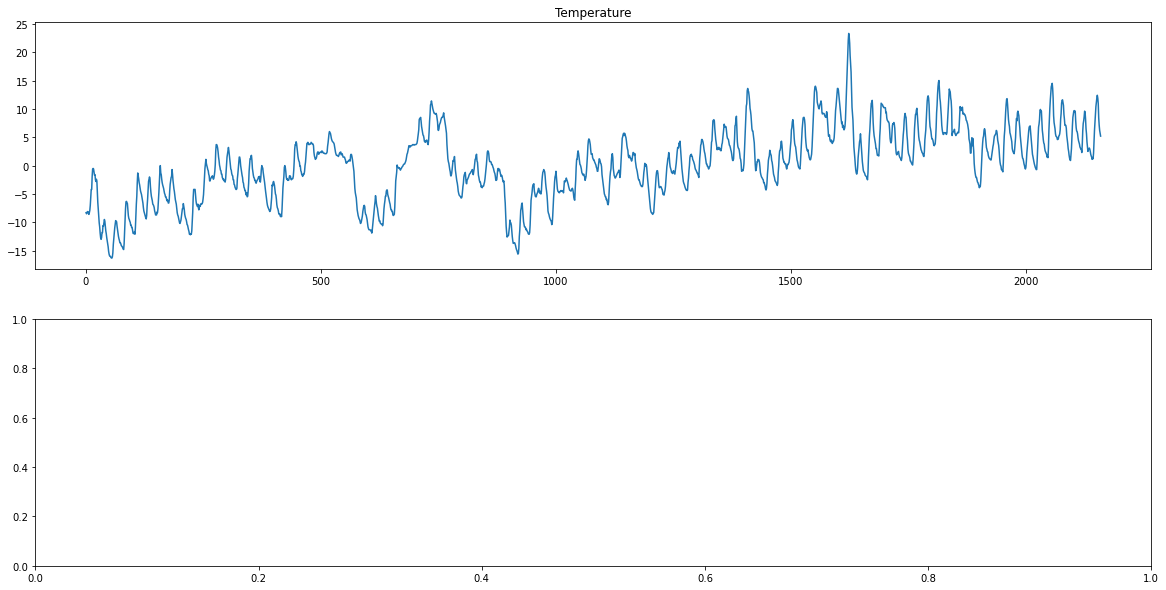

In [101]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(temps[0][temps[0]['month'].isin([1,2,3])]['temperature'])
ax1.set_title('Temperature')

ax2.plot(total[ (total['company'] == 0) & (total['year'] == 2013) & (total['month'].isin([1,2,3]))]['gas'])
ax2.set_title('Gas')

In [102]:
daily_temp = join_df[['temperature']].groupby([ join_df['month'], join_df['day'], join_df['hour'] ]).apply(lambda c: c.mean())
print(daily_temp.shape)
daily_temp

(2184, 1)


temperature
month day hour             
1     1   1       -2.683333
          2       -3.116667
          3       -3.483333
          4       -3.716667
          5       -4.050000
...                     ...
3     31  20      12.883333
          21      11.800000
          22      11.083333
          23      10.450000
          24       9.950000

[2184 rows x 1 columns]

In [103]:
#features = ['temperature', 'company', 'month', 'day', 'weekday', 'hour']
features = ['temperature', 'month', 'day', 'weekend', 'hour', 'Company_0', 'Company_1', 'Company_2', 'Company_3', \
            'Company_4','Company_5', 'Company_6']



x = join_df[features]
y = join_df['gas']

x = x.values
y = np.expand_dims(y.values, axis = 1)

#x_scaler = MinMaxScaler()
#x_scaler.fit(x)
#x = x_scaler.transform(x)

print(x.shape)
print(y.shape)

print(x[-5:])
print(y[-5:])

(90888, 12)
(90888, 1)
[[15.3  3.  31.   1.  20.   0.   0.   0.   0.   0.   0.   1. ]
 [14.   3.  31.   1.  21.   0.   0.   0.   0.   0.   0.   1. ]
 [13.3  3.  31.   1.  22.   0.   0.   0.   0.   0.   0.   1. ]
 [12.8  3.  31.   1.  23.   0.   0.   0.   0.   0.   0.   1. ]
 [12.4  3.  31.   1.  24.   0.   0.   0.   0.   0.   0.   1. ]]
[[244.162]
 [248.059]
 [231.181]
 [199.022]
 [190.212]]


# 모델 생성 및 학습

In [104]:

def make_model():    
    input_data  = layers.Input(shape=(12,))
    out         = layers.Dense(64, activation="relu")(input_data)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(32, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(16, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    output      = layers.Dense(1)(out)

    model        = tf.keras.Model(inputs = input_data, outputs = output)
    
    return model

In [105]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size = 0.2, random_state = 1311, shuffle=True)


In [133]:
from tensorflow.keras import backend as K 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def n_mae(y_true, y_pred):
    #y_true = y_scaler.inverse_transform(y_true)
    #y_pred = y_scaler.inverse_transform(y_pred)
    return K.mean((K.abs(y_true-y_pred))/y_true)

model = make_model()
model.compile(optimizer='adam', loss = n_mae)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.summary()

es = EarlyStopping(monitor='val_loss', mode = 'min' , patience = 50, verbose = 1)
folder_path = './Models/DNN_temp_one_hot'
file_path = folder_path + '/Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min',verbose=1, save_best_only=True)


history = model.fit(train_x, train_y, epochs = 300, batch_size = 128, \
                    shuffle= True, validation_data = (valid_x, valid_y), \
                    verbose = 1, callbacks = [mc, es])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                832       
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_20 (Batc (None, 16)                64  

569/569 [==============================] - 1s 1ms/step - loss: 0.1024 - val_loss: 0.0912

Epoch 00033: val_loss did not improve from 0.08501
Epoch 34/300
569/569 [==============================] - 1s 1ms/step - loss: 0.1010 - val_loss: 0.0871

Epoch 00034: val_loss did not improve from 0.08501
Epoch 35/300
569/569 [==============================] - 1s 1ms/step - loss: 0.1020 - val_loss: 0.0864

Epoch 00035: val_loss did not improve from 0.08501
Epoch 36/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0986 - val_loss: 0.0759

Epoch 00036: val_loss improved from 0.08501 to 0.07586, saving model to ./Models/DNN_temp_one_hot/Epoch_036_Val_0.076.hdf5
Epoch 37/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0982 - val_loss: 0.0794

Epoch 00037: val_loss did not improve from 0.07586
Epoch 38/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0975 - val_loss: 0.0743

Epoch 00038: val_loss improved from 0.07586 to 0.07431, saving model

569/569 [==============================] - 1s 1ms/step - loss: 0.0875 - val_loss: 0.0738

Epoch 00082: val_loss did not improve from 0.06882
Epoch 83/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0859 - val_loss: 0.0699

Epoch 00083: val_loss did not improve from 0.06882
Epoch 84/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0875 - val_loss: 0.0756

Epoch 00084: val_loss did not improve from 0.06882
Epoch 85/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0884 - val_loss: 0.0688

Epoch 00085: val_loss did not improve from 0.06882
Epoch 86/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0888 - val_loss: 0.0698

Epoch 00086: val_loss did not improve from 0.06882
Epoch 87/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0879 - val_loss: 0.0701

Epoch 00087: val_loss did not improve from 0.06882
Epoch 88/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0879 - val_

569/569 [==============================] - 1s 1ms/step - loss: 0.0846 - val_loss: 0.0684

Epoch 00132: val_loss did not improve from 0.06697
Epoch 133/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0821 - val_loss: 0.0700

Epoch 00133: val_loss did not improve from 0.06697
Epoch 134/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0850 - val_loss: 0.0669

Epoch 00134: val_loss improved from 0.06697 to 0.06689, saving model to ./Models/DNN_temp_one_hot/Epoch_134_Val_0.067.hdf5
Epoch 135/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0839 - val_loss: 0.0785

Epoch 00135: val_loss did not improve from 0.06689
Epoch 136/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0814 - val_loss: 0.0673

Epoch 00136: val_loss did not improve from 0.06689
Epoch 137/300
569/569 [==============================] - 1s 2ms/step - loss: 0.0832 - val_loss: 0.0700

Epoch 00137: val_loss did not improve from 0.06689
Epoch 138/30


Epoch 00183: val_loss improved from 0.06624 to 0.06594, saving model to ./Models/DNN_temp_one_hot/Epoch_183_Val_0.066.hdf5
Epoch 184/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0817 - val_loss: 0.0724

Epoch 00184: val_loss did not improve from 0.06594
Epoch 185/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0812 - val_loss: 0.0655

Epoch 00185: val_loss improved from 0.06594 to 0.06552, saving model to ./Models/DNN_temp_one_hot/Epoch_185_Val_0.066.hdf5
Epoch 186/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0819 - val_loss: 0.0714

Epoch 00186: val_loss did not improve from 0.06552
Epoch 187/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0808 - val_loss: 0.0676

Epoch 00187: val_loss did not improve from 0.06552
Epoch 188/300
569/569 [==============================] - 1s 2ms/step - loss: 0.0813 - val_loss: 0.0782

Epoch 00188: val_loss did not improve from 0.06552
Epoch 189/300
569/569 [======


Epoch 00234: val_loss did not improve from 0.06494
Epoch 235/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0815 - val_loss: 0.0716

Epoch 00235: val_loss did not improve from 0.06494
Epoch 236/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0809 - val_loss: 0.0682

Epoch 00236: val_loss did not improve from 0.06494
Epoch 237/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0804 - val_loss: 0.0689

Epoch 00237: val_loss did not improve from 0.06494
Epoch 238/300
569/569 [==============================] - 1s 2ms/step - loss: 0.0809 - val_loss: 0.0737

Epoch 00238: val_loss did not improve from 0.06494
Epoch 239/300
569/569 [==============================] - 1s 2ms/step - loss: 0.0797 - val_loss: 0.0658

Epoch 00239: val_loss did not improve from 0.06494
Epoch 240/300
569/569 [==============================] - 1s 1ms/step - loss: 0.0809 - val_loss: 0.0694

Epoch 00240: val_loss did not improve from 0.06494
Epoch 241/300
569/

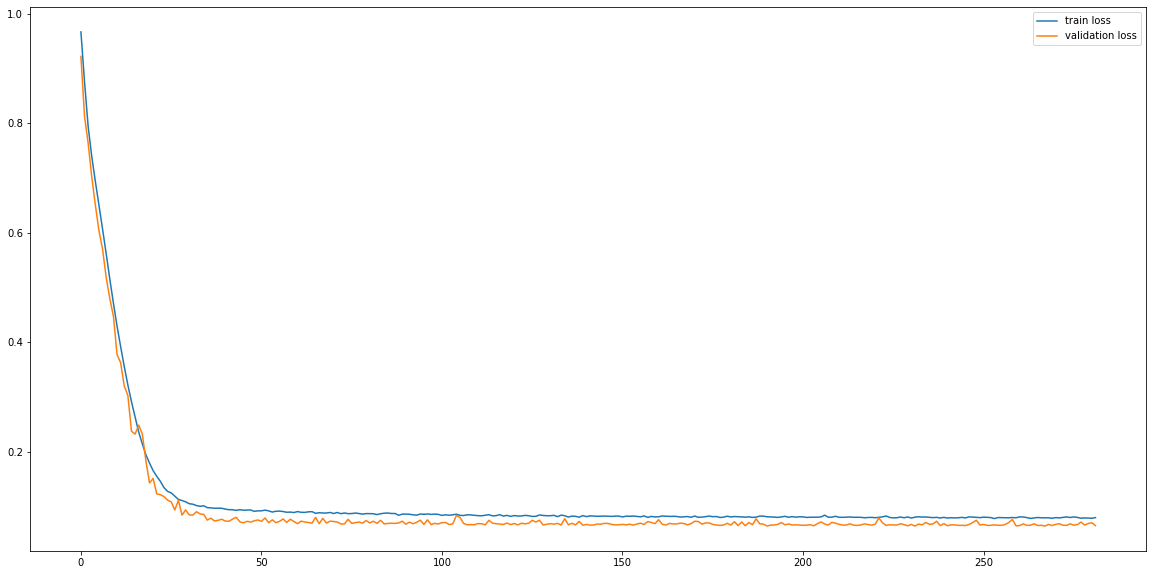

In [148]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [185]:
model = make_model()
model.load_weights('./Models/DNN_temp_one_hot/Epoch_232_Val_0.065.hdf5')

# 학습

In [ ]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

# 추론 및 결과 제출

In [186]:
test = pd.read_csv('./Submission/test.csv')
submission = pd.read_csv('./Submission/sample_submission.csv')

In [187]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [188]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [189]:
test['datetime'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['company'] = test['일자|시간|구분'].str.split(' ').str[2]

In [190]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['weekday'] = test['datetime'].dt.weekday
test['weekend'] = 0
test.loc[test['weekday'] >= 5, 'weekend'] = 1

In [191]:
# creating one hot encoder object 
onehotencoder = OneHotEncoder()

#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(test[['company']]).toarray()

company_one_hot = pd.DataFrame(X, columns = ["Company_"+str(int(i)) for i in range(X.shape[1])]) 

test = pd.concat([test, company_one_hot], axis =1 )
test = test.drop(['company'], axis =1)


In [192]:
#test['company'] = test['company'].map(company_map)

In [193]:
test.head()

,일자|시간|구분,datetime,hour,year,month,day,weekday,weekend,Company_0,Company_1,Company_2,Company_3,Company_4,Company_5,Company_6
0,2019-01-01 01 A,2019-01-01,1,2019,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 02 A,2019-01-01,2,2019,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 03 A,2019-01-01,3,2019,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 04 A,2019-01-01,4,2019,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 05 A,2019-01-01,5,2019,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(15120, 16)
(2160, 7)
             datetime  temperature  year  month  day  weekday  hour
0 2015-01-01 00:00:00         -6.2  2015      1    1        3     1
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5
0   -6.2
1   -7.4
2   -8.0
3   -8.4
4   -8.8
Name: temperature, dtype: float64
2155    13.6
2156    13.2
2157    12.7
2158    12.5
2159    12.4
Name: temperature, dtype: float64
          일자|시간|구분   datetime  hour  year  month  day  weekday  weekend  \
0  2019-01-01 01 A 2019-01-01     1  2019      1    1        1        0   
1  2019-01-01 02 A 2019-01-01     2  2019      1    1        1        0   
2  2019-01-01 03 A 2019-01-01     3  2019      1    1        1        0   
3  2019-01-01 04 A 2019-01-01     4  2019      1    1        1        0   
4  2019-01-01 05 

/home/bwj/anaconda3/envs/tf-env/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


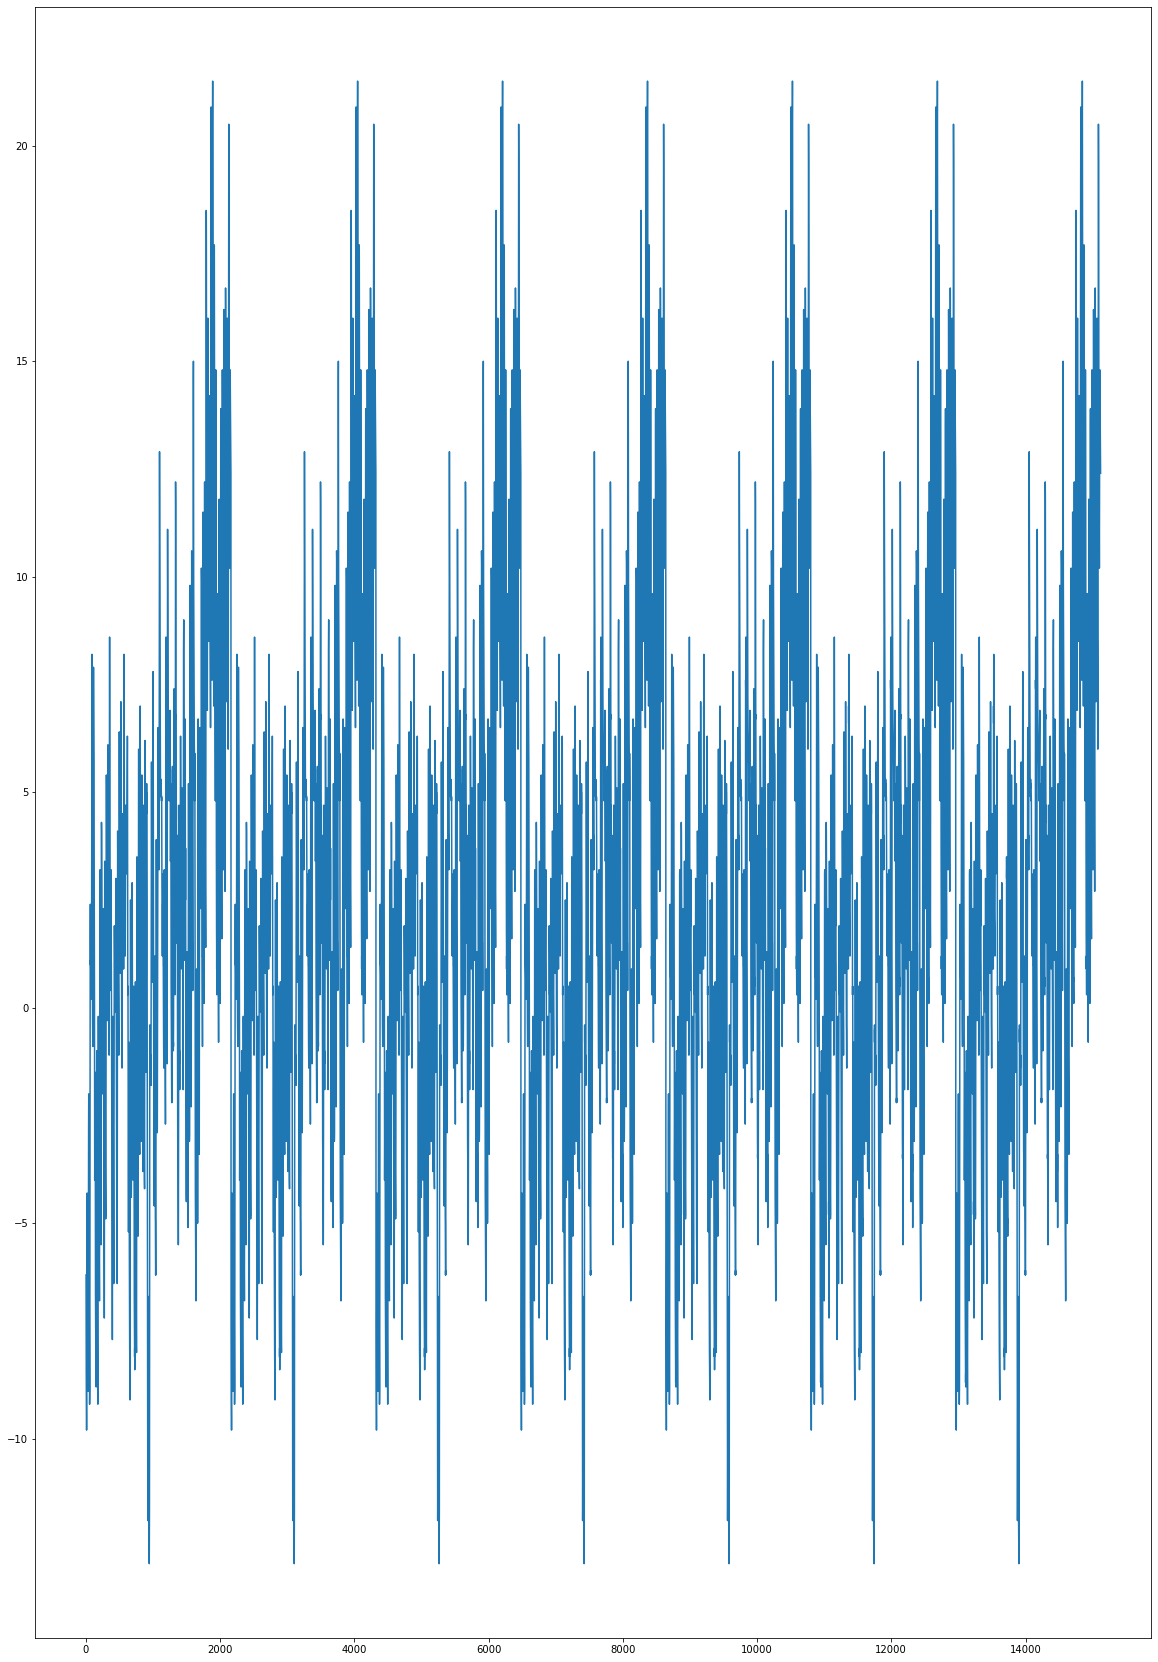

In [203]:
#test_combined = pd.merge(test, daily_temp, how = 'left', left_on = ['month', 'day', 'hour'], right_on = ['month', 'day', 'hour'])


for i in range(7):
    test['temperature'].iloc[i*(2160): (i+1)*2160] = temps[2][temps[2]['month'].isin([1,2,3])]['temperature']
    

    
print(temps[2][temps[2]['month'].isin([1,2,3])]['temperature'].iloc[:5])
print(temps[2][temps[2]['month'].isin([1,2,3])]['temperature'].iloc[-5:])


#print(test_combined.iloc[:5])
#print(test_combined.iloc[-5:])

print(test.iloc[:5])
print(test.iloc[-5:])

#print(test_combined[test_combined['Company_1'] == 1].head())
#plt.plot(test['temperature'])


6
-2.2535648148148146
0.6450462962962963
-0.28824074074074063
-1.2174537037037034
-0.9629166666666665
-1.5425

-0.9056867283950617
1.5315817901234567


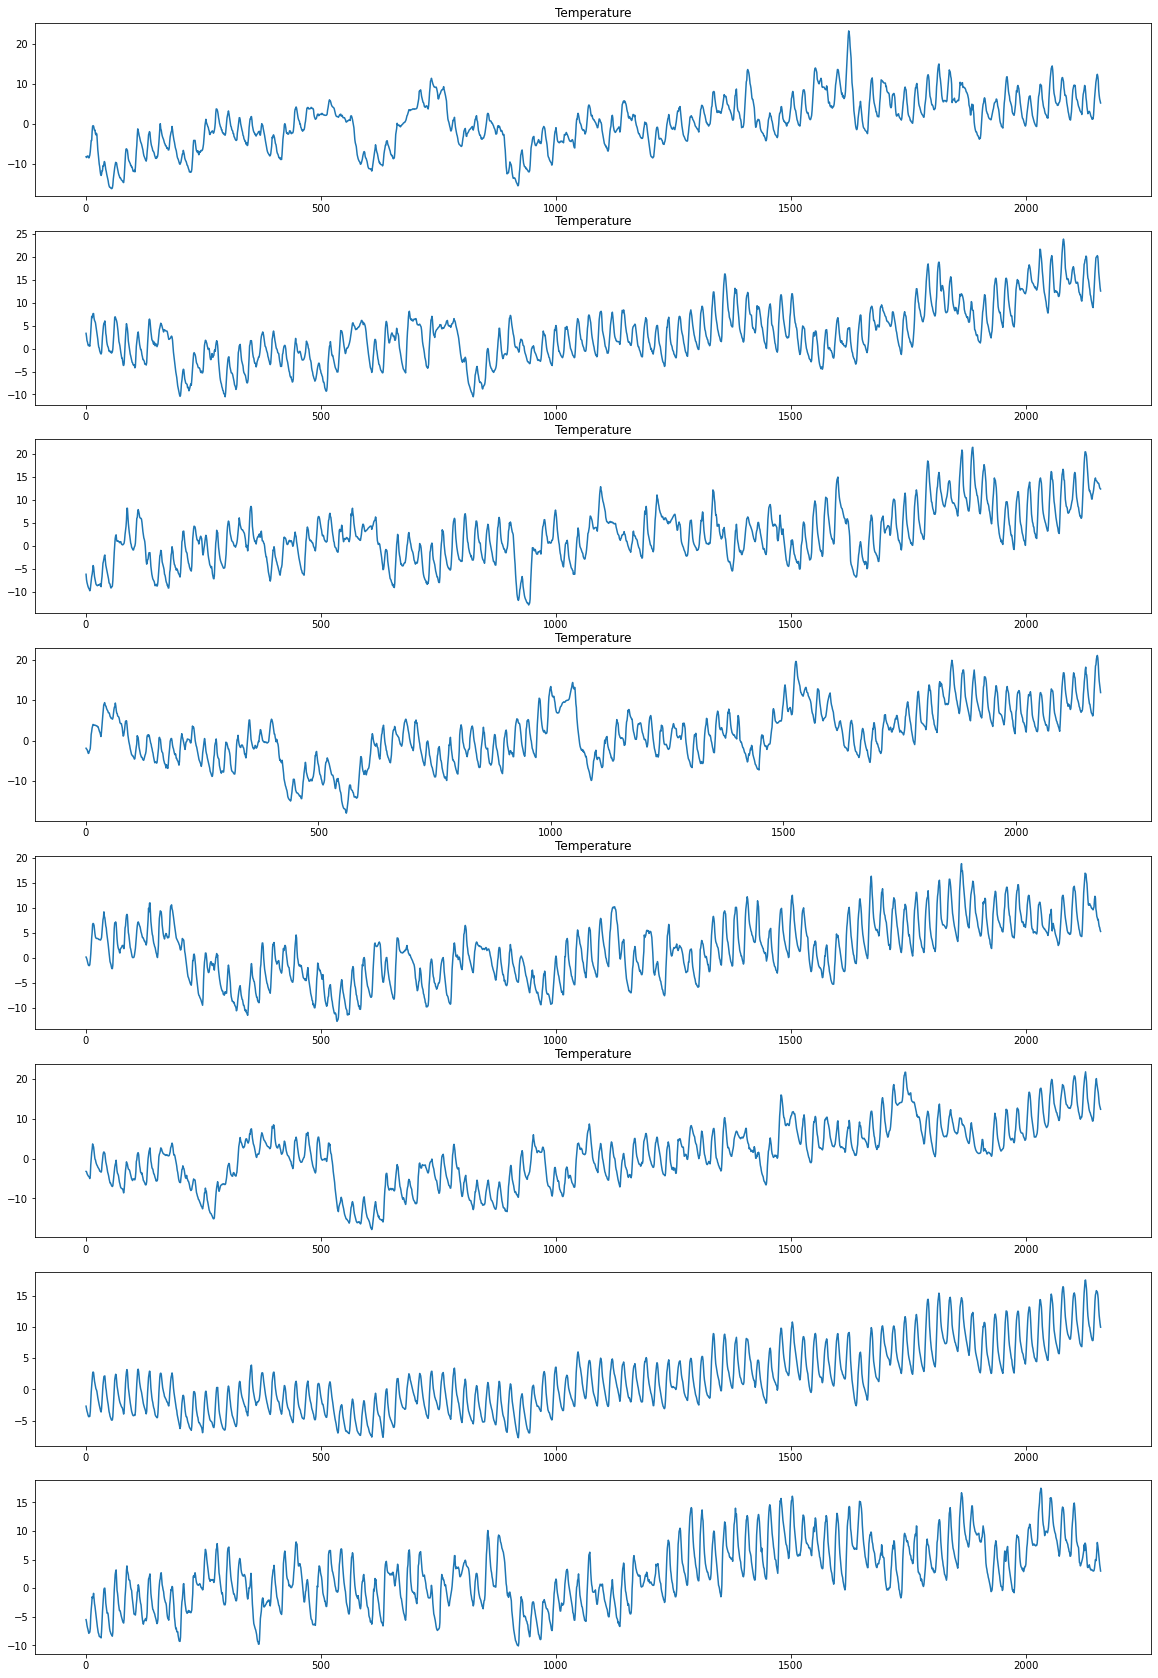

In [184]:
temp = pd.read_csv('./Data/temperature_2019.csv', encoding='cp949')
#temp.columns = header
temp = temp[['일시', '기온(°C)']]
temp.columns = ['datetime', 'temperature']
temp['datetime'] = pd.to_datetime(temp['datetime'])
temp['year'] = temp['datetime'].dt.year
temp['month'] = temp['datetime'].dt.month
temp['day'] = temp['datetime'].dt.day
temp['weekday'] = temp['datetime'].dt.weekday
temp['hour'] = temp['datetime'].dt.hour + 1

from pylab import rcParams
rcParams['figure.figsize'] = 20, 30
fig = plt.figure()

ax1 = fig.add_subplot(811)
ax2 = fig.add_subplot(812)
ax3 = fig.add_subplot(813)
ax4 = fig.add_subplot(814)
ax5 = fig.add_subplot(815)
ax6 = fig.add_subplot(816)
ax7 = fig.add_subplot(817)
ax8 = fig.add_subplot(818)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]


for i in range(len(axes) - 1):
    axes[i].plot(temps[i][temps[i]['month'].isin([1,2,3])]['temperature'])
    axes[i].set_title('Temperature')


#ax2.plot(total[ (total['company'] == 0) & (total['year'] == 2013) & (total['month'].isin([1,2,3]))]['gas'])
#

ax7.plot(test_combined[test_combined['Company_0'] == 1]['temperature'])
#ax7.set_title('Gas')

print(len(temps))



ax8.plot(temp[temp['month'].isin([1,2,3])]['temperature'])





for i in range(len(temps)):
    diff = (temps[i][temps[i]['month'].isin([1,2,3])]['temperature'] - temp[temp['month'].isin([1,2,3])]['temperature']).mean()
    print(diff)

print()
print((test_combined[test_combined['Company_0'] == 1]['temperature'] - temp[temp['month'].isin([1,2,3])]['temperature']).mean())
print(test_combined[test_combined['Company_2'] == 1]['temperature'].mean())

In [204]:
#test_x = test_combined[features]
test_x = test[features]


print(test_x.head())
test_x = test_x.values

#test_x[59:, 0]
#test_x = x_scaler.transform(test_x)
#Etest_x[:5]



   temperature  month  day  weekend  hour  Company_0  Company_1  Company_2  \
0         -6.2      1    1        0     1        1.0        0.0        0.0   
1         -7.4      1    1        0     2        1.0        0.0        0.0   
2         -8.0      1    1        0     3        1.0        0.0        0.0   
3         -8.4      1    1        0     4        1.0        0.0        0.0   
4         -8.8      1    1        0     5        1.0        0.0        0.0   

   Company_3  Company_4  Company_5  Company_6  
0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0  


In [ ]:
test_x = xgb.DMatrix(test_x)

In [205]:
preds = model.predict(test_x)
preds[:5]

array([[2080.9524],
       [1888.8986],
       [1827.9095],
       [1889.3989],
       [1986.4591]], dtype=float32)

In [206]:
submission['공급량'] = preds

In [207]:
submission.to_csv('./Submission/dnn_temp_one_hot.csv', index=False)